# Reading New TEC Data and Producing Output Files

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [5]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA/EIAmerging')
import functions

In [ ]:
functions = il.reload(functions)

events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/tec_data/{event}/'
files = os.listdir(path)
files = [path + i for i in files]

for f in files:
    if f[-4:] != '.txt':
        files.remove(f)
print('No. of files to process:', len(files))



glat_lim = 40

glon_min = -60
glon_max = -40
mlon_min = 15
mlon_max = 25
zone_mlon = '20E'

    
tec_g = []
columns = ['GDLAT', 'GLON', 'TEC', 'DT']
grnd_tec = pd.DataFrame(columns=columns)

def process_file(f):
    # Read function passed continuously during multiple processing to quicken the process
    df = pd.read_csv(f, sep=r'\s+')
    d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
    df['DT'] = d
    # Dropping unnecassary columns from the Dataframe
    df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
    if 'GDALT' in df.columns:
        df = df.drop(['GDALT'], axis=1)
    df = df[(df.GDLAT > -glat_lim) & (df.GDLAT < glat_lim) & (df.GLON > glon_min) & (df.GLON < glon_max)].reset_index(drop=True)
    return df    
# Speeding the process by using parallel processing
tec_g = p_map(process_file, files)  # Parallel processing with progress bar
print('1')
grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
grnd_tec0 = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])



# Reading the Kp, F10.7 index values for all the days and filtering undesired points where Kp > 3
file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/kp_f107_data.txt'
kp = pd.read_csv(file,sep=r'\s+')
year = 2023
date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
m, d = zip(*date_kp)
kp['DT'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
kp['kp'] = [i/10 for i in kp.Kp]
kp = kp.drop(['Year', 'Hour','Kp'], axis = 1)
# the below command is messing up the kp values as it is trying to fit the kp value 
# based on weighted average of all the known points surrounding it
grnd_tec0 = pd.merge_asof(grnd_tec0.sort_values('DT'), 
            kp.sort_values('DT'), on='DT', direction='nearest')


# Reading the By, Bz index values for all the days
file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/by_bz_data.txt'
imf = pd.read_csv(file,sep=r'\s+')
year = imf.Year[0]
date_imf = [functions.day_to_date(i, year) for i in imf.DOY]
m, d = zip(*date_imf)
imf['DT'] = [dt.datetime(year, j, i, k, l, 0) for i,j,k,l in zip(d,m,imf.Hour,imf.Minute)]
imf = imf.drop(['Year','Hour','Minute', 'DOY'], axis = 1)
grnd_tec0 = pd.merge_asof(grnd_tec0.sort_values('DT'), 
            imf.sort_values('DT'), on='DT', direction='nearest')



#grnd_tec0 = merged_data.drop(['date'], axis = 1)
print('2')

# Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
t_start = dt.datetime.now() # just a timer
with Pool(40) as pool:
    p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
pool.close()
pool.join()
# Separating the data from output list 
sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)



# Reordering the outputs and applying further conditions on magnetic coordinates
grnd_temp = pd.DataFrame({'DT': sat_date, 'DOY': grnd_tec0.DOY, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt, 'kp':grnd_tec0.kp, 'By':grnd_tec0.BY, 'Bz':grnd_tec0.BZ, 'F10.7':grnd_tec0['F10.7']})
grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= mlon_max) & (grnd_tec1.MLON >= mlon_min)].reset_index(drop=True)
grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)




# Writing the output into csv files for easy post processing
grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/feb_22_24_2023.csv', index=False)

t_total = dt.datetime.now() - t_start
print(t_total)

# Adding SMYH, SMI and SMR indices 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gzip
import os
import io
import datetime as dt

In [32]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [33]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/supermag_data/'
file = path + '20250207-00-27-supermag.txt'

df = pd.read_csv(file, delim_whitespace=True)

# Combine date and time columns into a single datetime column
df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Drop the original date/time columns if not needed
df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second'])

# Set the Timestamp as the index
#df.set_index('time', inplace=True)

df_int = pd.DataFrame({
    'time': df['time'][:-1] + dt.timedelta(seconds=30),
    'SME': (df['SME'][:-1].values + df['SME'][1:].values) / 2,
    'SMR': (df['SMR'][:-1].values + df['SMR'][1:].values) / 2,
})

df = pd.concat([df, df_int]).sort_values(by='time').reset_index(drop=True)
print(df)

           SME    SMR                time
0        265.0 -14.10 2023-01-01 00:00:00
1        263.5 -14.05 2023-01-01 00:00:30
2        262.0 -14.00 2023-01-01 00:01:00
3        267.5 -14.00 2023-01-01 00:01:30
4        273.0 -14.00 2023-01-01 00:02:00
...        ...    ...                 ...
1051194   61.0  -0.80 2023-12-31 23:57:00
1051195   59.0  -0.80 2023-12-31 23:57:30
1051196   57.0  -0.80 2023-12-31 23:58:00
1051197   57.0  -0.80 2023-12-31 23:58:30
1051198   57.0  -0.80 2023-12-31 23:59:00

[1051199 rows x 3 columns]


In [37]:
data = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/{event}.csv')
data['DT'] = pd.to_datetime(data['DT'])

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])

# Convert MLT to timedelta
data['MLT_del'] = pd.to_timedelta(data['MLT'], unit='h')

# Normalize DT (set time to 00:00:00) and add MLT shift
data['MLT_dt'] = (data['DT']).dt.normalize() + data['MLT_del']
dt_hours = data['DT'].dt.hour
data.loc[dt_hours < data['MLT'], 'MLT_dt'] -= pd.Timedelta(days=1) # this is to accomodate for the day change for this negative longitude regions

#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'] >= 24, data['MLT_dt'] - pd.Timedelta(days=1))
#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'], data['MLT_dt'] + pd.Timedelta(days=1))
data = data.drop(columns=['MLT_del', 'index'])

print(data)
print(data['MLT_dt'][20139:20145])

f10 = sum(data['F10.7'])/len(data['F10.7'])
print()
print('Average F10.7 value', f10)


                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  5.0   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  5.0   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  5.0   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7 -8.6   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7 -8.6   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7 -8.6   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  
0       0

In [19]:
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + 'symh00584732.txt'

data_symh = []

with open(file, 'r') as file:
    for line in file:
        # Extract date and hour from the header (positions 14-23)
        date_str = '20'+line[12:18]  # Format: YYYYMMDD
        hour_str = line[19:21]  # Format: HH
        
        # Convert to datetime
        base_time = dt.datetime.strptime(date_str + hour_str, "%Y%m%d%H")
        
        # Extract SYMH values (positions 44 onwards, 60 values)
        symh_values = line[42:].split()
        
        # Generate timestamps for each minute
        for i, symh in enumerate(symh_values):
            timestamp = base_time + dt.timedelta(minutes=i, seconds=30) # added extra 30 seconds here for easy time matching with original tec data
            data_symh.append([timestamp, int(symh)])  # Convert symh to integer

# Create a DataFrame
df = pd.DataFrame(data_symh, columns=["time", "SYMH"])

# Save to CSV (optional)
df.to_csv(path+"symh_data.csv", index=False)

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])
print(data)
time_dif = (data.DT[0] - data.MLT_dt[0])/pd.Timedelta(hours=1)
time_dif = round(time_dif,2)
print(f'UT = MLT + {time_dif}hr')

data.to_csv(path+f'full_{event}.csv')

                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  5.0   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  5.0   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  5.0   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7 -8.6   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7 -8.6   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7 -8.6   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  SYMH  
0  

# Plotting the Results

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools


In [10]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [26]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + f'full_{event}.csv'

df = pd.read_csv(file)
df = df[(df['MLAT'] <= 31) & (df['MLAT'] >= -30)].reset_index()

df['DT'] = pd.to_datetime(df['DT'])
df['MLT_dt'] = pd.to_datetime(df['MLT_dt'])
df = df.drop(columns = ['index','Unnamed: 0'])


if event == 'feb_22_24_2023':
    start_date = '2023-02-21'
    end_date = '2023-02-26'
elif event == 'may_9_11_2024':
    start_date = '2024-05-09'
    end_date = '2024-05-11'
#df = df[(df['MLT_dt'] >= start_date) & (df['MLT_dt'] <= end_date)]
print(df)


time_dif = (df.DT[0] - df.MLT_dt[0])/pd.Timedelta(hours=1)
time_dif = round(time_dif,2)
print(f'UT = MLT + {time_dif}hr')

                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   9.78413 -29.680578  19.898924  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51060 -29.322611  19.848463  0.7  5.0   
2      2023-02-20 00:02:30   51   9.28649 -29.297171  19.953796  0.7  5.0   
3      2023-02-20 00:02:30   51   8.85789 -29.673628  20.005725  0.7  5.0   
4      2023-02-20 00:02:30   51  14.66610 -27.790924  19.855783  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
835902 2023-02-26 23:57:30   57  28.70460  26.439440  20.162229  5.7 -8.6   
835903 2023-02-26 23:57:30   57  28.84990  25.986403  20.231435  5.7 -8.6   
835904 2023-02-26 23:57:30   57  28.52710  25.527155  20.299675  5.7 -8.6   
835905 2023-02-26 23:57:30   57  28.44990  27.450390  20.175425  5.7 -8.6   
835906 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  SYMH  
0  

In [27]:
# Choice - Whether to plot across MLT or DT
time_types = ['MLT_dt', 'DT']
t_coord = time_types[1]

# Define the MLAT bins from -30 to 30 with a step of 1
mlat_bins = np.arange(-30,31,1)
df['MLAT_bin'] = pd.cut(df['MLAT'], bins=mlat_bins, labels=mlat_bins[:-1])

# Removing the Missing Data points of By and Bz
df.loc[(df['By'] == 999.9) & (df['Bz'] == 999.9), ['By', 'Bz']] = np.nan

df1 = df

if t_coord == 'MLT_dt':

    df1['MLT_dt_bin'] = df1['MLT_dt'].dt.floor('10T')
    df1 = df1.drop(columns = ['MLT', 'DT', 'MLAT', 'DOY'])
    df1.rename(columns={'MLT_dt': 'time'}, inplace=True)
    df1.rename(columns={'MLT_dt_bin': 'time_bin'}, inplace=True)

elif t_coord == 'DT':
    
    df1['DT_bin'] = df1['DT'].dt.floor('10T')
    df1 = df.drop(columns = ['MLT', 'MLT_dt', 'MLAT', 'DOY'])
    df1.rename(columns={'DT': 'time'}, inplace=True)
    df1.rename(columns={'DT_bin': 'time_bin'}, inplace=True)

# Group by DT and MLAT_bin, then take the mean of other columns
df1 = df1.groupby(['time_bin', 'MLAT_bin']).mean(numeric_only=True).reset_index()
df1['MLAT_bin'] = df1['MLAT_bin'].astype(int)
df1.rename(columns={'MLAT_bin': 'MLAT'}, inplace=True)
df1.rename(columns={'time_bin': 'time_dt'}, inplace=True)
print(df1)


                  time_dt  MLAT        TEC   kp        By        Bz  F10.7  \
0     2023-02-20 00:00:00   -30   9.764315  0.7  4.942222  0.760000  156.3   
1     2023-02-20 00:00:00   -29  10.006591  0.7  4.943125  0.753750  156.3   
2     2023-02-20 00:00:00   -28  11.661862  0.7  4.937826  0.790435  156.3   
3     2023-02-20 00:00:00   -27  11.538943  0.7  4.941500  0.765000  156.3   
4     2023-02-20 00:00:00   -26  17.672808  0.7  4.935000  0.810000  156.3   
...                   ...   ...        ...  ...       ...       ...    ...   
60475 2023-02-26 23:50:00    25  29.267020  5.7 -8.232000 -2.382000  155.9   
60476 2023-02-26 23:50:00    26  28.898200  5.7 -8.140000 -1.995000  155.9   
60477 2023-02-26 23:50:00    27  28.785400  5.7 -8.600000 -3.930000  155.9   
60478 2023-02-26 23:50:00    28        NaN  NaN       NaN       NaN    NaN   
60479 2023-02-26 23:50:00    29        NaN  NaN       NaN       NaN    NaN   

              SME        SMR  SYMH  
0       56.166667   7.9722

In [28]:
if t_coord == 'MLT_dt':
    # Approximate first stable Kp start
    tolerance = 0.25
    for i in range(len(df1) - 1):
        if abs(df1["kp"].iloc[i] - df1["kp"].iloc[i + 1]) <= tolerance:
            first_stable_time = df1["time_dt"].iloc[i]  # Estimate start point
            break
    else:
        first_stable_time = df1["time_dt"].iloc[0]  # Fallback to first timestamp if no stable region found
    
    # Adjust binning based on estimated start
    bin_start = first_stable_time.floor("3H")  # Floor to nearest 3-hour mark
    df1["custom_3h_bin"] = (df1["time_dt"] - bin_start) // pd.Timedelta(hours=3)  # Compute bins dynamically
    df1["custom_3h_bin"] = bin_start + df1["custom_3h_bin"] * pd.Timedelta(hours=3)  # Align bins
    
    # Aggregate Kp values per estimated 3-hour bin (taking the first or mean)
    kp_binned = df1.groupby("custom_3h_bin")["kp"].first().dropna()
    print(kp_binned)

elif t_coord == 'DT':

    file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/kp_f107_data.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    year = kp.Year[0]
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['DT'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp_bin = []
    t_bin = []
    for i in range(len(kp.kp)):
        if i%3 == 0:
            kp_bin.append(kp.kp[i])
            t_bin.append(kp.DT[i])
        continue
    kp_binned = pd.DataFrame()
    kp_binned['time_dt'] = t_bin
    kp_binned['kp'] = kp_bin
    print(kp_binned)
    


               time_dt   kp
0  2023-02-20 00:00:00  0.7
1  2023-02-20 03:00:00  0.3
2  2023-02-20 06:00:00  1.7
3  2023-02-20 09:00:00  3.0
4  2023-02-20 12:00:00  2.3
5  2023-02-20 15:00:00  1.7
6  2023-02-20 18:00:00  2.3
7  2023-02-20 21:00:00  1.7
8  2023-02-21 00:00:00  3.0
9  2023-02-21 03:00:00  3.3
10 2023-02-21 06:00:00  3.3
11 2023-02-21 09:00:00  4.0
12 2023-02-21 12:00:00  3.7
13 2023-02-21 15:00:00  1.7
14 2023-02-21 18:00:00  1.0
15 2023-02-21 21:00:00  1.3
16 2023-02-22 00:00:00  1.3
17 2023-02-22 03:00:00  0.3
18 2023-02-22 06:00:00  1.3
19 2023-02-22 09:00:00  1.7
20 2023-02-22 12:00:00  2.0
21 2023-02-22 15:00:00  2.0
22 2023-02-22 18:00:00  2.0
23 2023-02-22 21:00:00  2.3
24 2023-02-23 00:00:00  4.3
25 2023-02-23 03:00:00  3.7
26 2023-02-23 06:00:00  3.0
27 2023-02-23 09:00:00  2.7
28 2023-02-23 12:00:00  2.7
29 2023-02-23 15:00:00  4.0
30 2023-02-23 18:00:00  3.3
31 2023-02-23 21:00:00  3.7
32 2023-02-24 00:00:00  2.3
33 2023-02-24 03:00:00  1.0
34 2023-02-24 06:00:

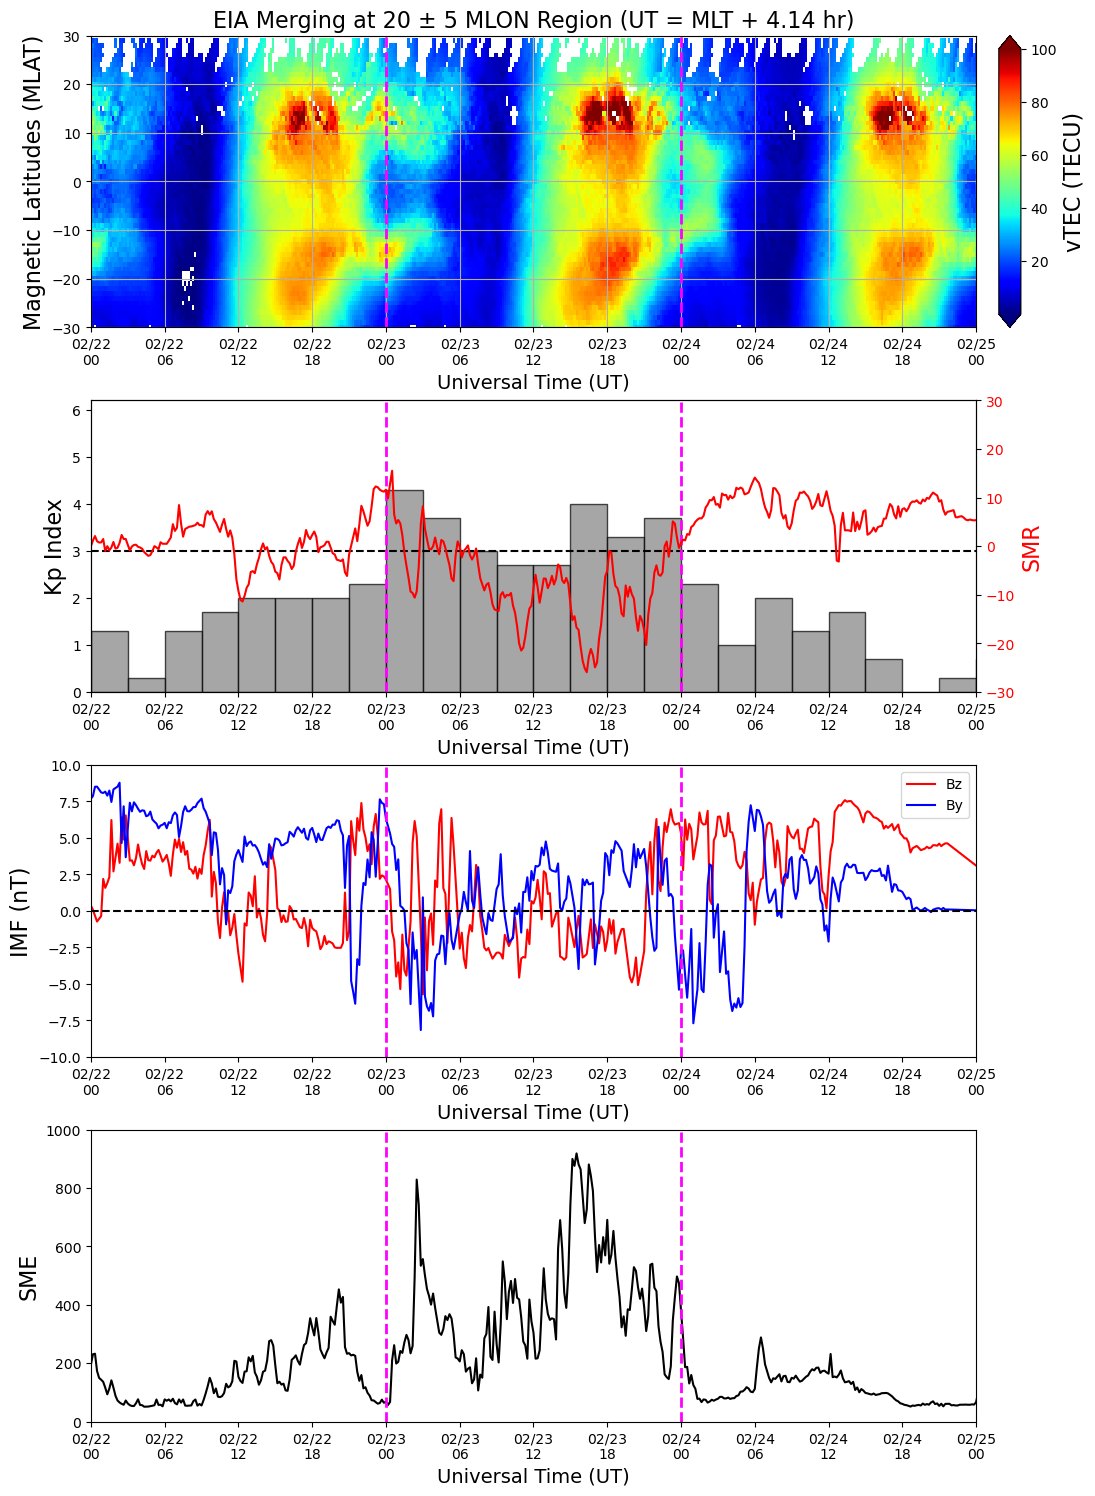

In [29]:
pivot_df = df1.pivot(index='MLAT', columns='time_dt', values='TEC')
X,Y = np.meshgrid(pivot_df.columns.unique(), pivot_df.index.unique())
Z = pivot_df.values.reshape(X.shape)


fig = plt.figure(figsize=(12,18))
specs = fig.add_gridspec(4, 2, width_ratios = [1, 0.025], height_ratios=[1,1,1,1], hspace=0.25, wspace=0.05)

# First Plot - TEC
ax1 = fig.add_subplot(specs[0,0])
pcm = ax1.pcolormesh(X, Y, Z, shading='auto', vmax = 100, cmap='jet')

#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%m/%d'))
#ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
#ax1.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
#ax1.set_xlabel('Magnetic Local Time (MLT)', fontsize=16)
ax1.set_ylabel('Magnetic Latitudes (MLAT)', fontsize=16)
ax1.set_title(f'EIA Merging at 20 ± 5 MLON Region (UT = MLT + {time_dif} hr)', fontsize = 16)
ax1.set_ylim(-30,30)
ax1.grid(True)
cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'vTEC (TECU)', extend='both')
cbar.set_label('vTEC (TECU)', fontsize = 16)


df2 = df1.drop(columns=['MLAT'])
df2 = df2.groupby(['time_dt']).mean().reset_index()



# Second Plot - kp index and F10.7 values
ax2 = fig.add_subplot(specs[1,0])
if t_coord == 'MLT_dt':
    ax2.bar(kp_binned.index, kp_binned.values, width=pd.Timedelta(hours=3), align="edge", 
            edgecolor="black", color="gray", alpha=0.7, label="Kp Index")
    ax2.set_ylim(0,max(kp_binned.values)+0.5)
elif t_coord == 'DT':
    ax2.bar(kp_binned.time_dt, kp_binned.kp, width=pd.Timedelta(hours=3), align='edge',
           edgecolor='black', color='gray', alpha=0.7, label='Kp Index')
    ax2.set_ylim(0,max(kp_binned.kp)+0.5)
#ax2.hist(dt_kp, bins=np.arange(min(dt_kp), max(dt_kp), np.timedelta64(6, 'h')), weights=kp, color='blue', edgecolor='black', alpha=0.7)  
ax2.set_ylabel('Kp Index', fontsize=16, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.axhline(3, color='black', linestyle='--')

ax2_twin = ax2.twinx()
ax2_twin.plot(df2.time_dt, df2.SMR, label='SMR', color='red')
ax2_twin.set_ylabel('SMR', fontsize=16, color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.set_ylim(-30, 30)

# Third Plot - SME and SMR indices 
ax3 = fig.add_subplot(specs[2,0])
df3 = df2[(df2['By'] < 100) & (df2['Bz'] < 100)].reset_index(drop=True)
ax3.plot(df3.time_dt, df3.Bz, color = 'red', label='Bz')
ax3.plot(df3.time_dt, df3.By, color='blue', label='By')
ax3.set_ylabel('IMF (nT)', color='black', fontsize=16)
ax3.tick_params(axis='y', labelcolor='black')
ax3.axhline(0, color = 'black', linestyle='--')
ax3.set_ylim(-10,10)
ax3.legend()
#ax3.grid()

# Fourth plot - SYMH index
ax4 = fig.add_subplot(specs[3,0])
ax4.plot(df2.time_dt, df2.SME, color='black')
ax4.set_ylabel('SME', fontsize=16)
ax4.set_ylim(0,1000)

for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
    # Add vertical lines at specific datetime points
    ax.axvline(pd.Timestamp('2023-02-23 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    ax.axvline(pd.Timestamp('2023-02-24 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    if t_coord == 'MLT_dt':
        ax.set_xlabel('Magnetic Local Time (MLT)', fontsize=14)
    elif t_coord == 'DT':
        ax.set_xlabel('Universal Time (UT)', fontsize=14)
    xlim_start = pd.Timestamp(df2.time_dt.iloc[0])
    xlim_end = pd.Timestamp(df2.time_dt.iloc[-1])
    xlim_start = pd.Timestamp('2023-02-22 00:00:00')
    xlim_end = pd.Timestamp('2023-02-25 00:00:00')
    ax.set_xlim(xlim_start, xlim_end)
    

fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/{start_date}_to_{end_date}.jpg', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()


# Processing the Fabry-Perot Instrument Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il


In [3]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

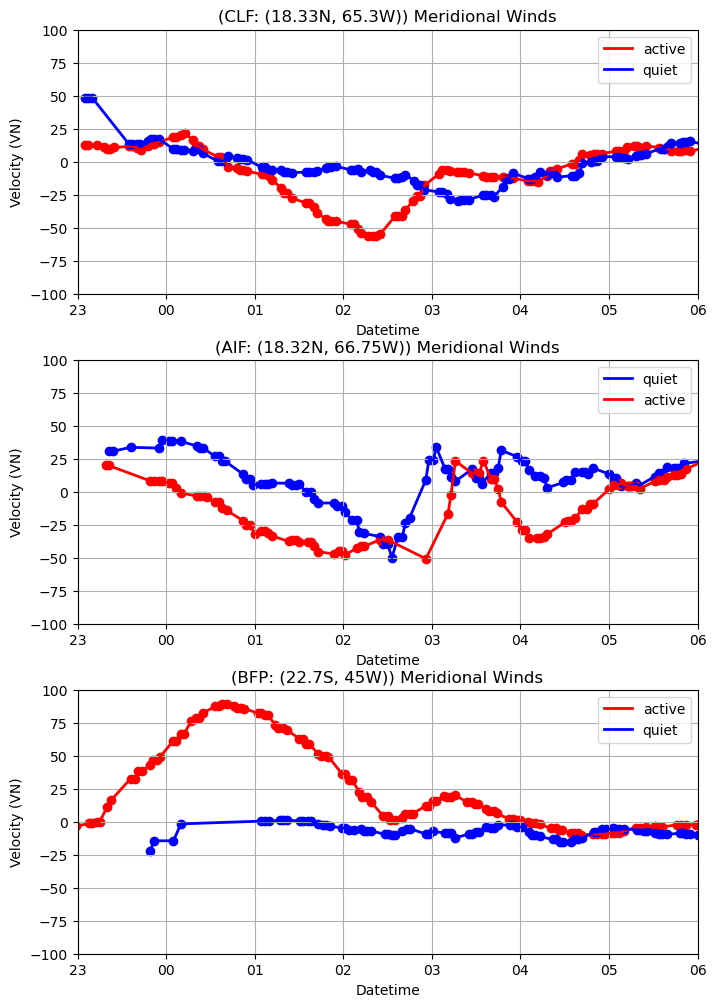

In [51]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

stations = ['clf','aif', 'bfp']
s_lons = ['(18.33N, 65.3W)', '(18.32N, 66.75W)', '(22.7S, 45W)']
color = ['blue', 'red']
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/fabry_perot_data/'

vn_q = []
time_q = []
vn_a = []
time_a = []

i = 0
# Plot the time series
fig = plt.figure(figsize=(8, 12))
specs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0.25)

for s, sl in zip(stations, s_lons):
    file_path = path + s + '/'
    files_list = os.listdir(file_path)
    files = [file_path + i for i in files_list]

    data = []

    for f in files:
        if f[-4:] != '.txt':
            continue

        #name = f.split('/')[-1][:9]
        save_path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/fabry_perot_data/{s}.csv'
        
        columns = [
            "YEAR", "MONTH", "DAY", "HOUR", "MIN", "SEC", "RECNO", "KINDAT", "KINST",
            "UT1_UNIX", "UT2_UNIX", "ALTB", "ALTE", "GDLAT", "GLON",
            "VN1", "VN2", "DVN1", "DVN2", "GVN1", "GVN2", "DGVN1", "DGVN2", "FPI_DATAQUAL"
        ]
        df_t = pd.read_csv(f, sep='\s+', names=columns, skiprows=1)
        
        # Relevant columns
        df_t = df_t[["YEAR", "MONTH", "DAY", "HOUR", "MIN", "VN1", "DVN1", "VN2", "DVN2"]]

        df_t = df_t.rename(columns={"YEAR": "year", "MONTH": "month", "DAY": "day", "HOUR": "hour", "MIN": "minute"})
        
        # Combine the columns into a single datetime column
        df_t['DATETIME'] = pd.to_datetime(df_t[["year", "month", "day", "hour", "minute"]])

        df_t = df_t.drop(columns=['year', 'month', 'day', 'hour', 'minute'])
    
        # Drop any rows with NaNs in VN1 or VN2
        #df = df.dropna(subset=["VN1", "VN2"])
        
        data.append(df_t)
    
    ax = fig.add_subplot(specs[i,0])
    i = i + 1

    for df in data:
        
        # Apply smoothing for VN1 (time-based window)
        df = df.set_index('DATETIME')  # Set the datetime column as the index for rolling()
        df['VN1_SMOOTH'] = df['VN1'].rolling('40min', center=True).mean()  # 20-minute rolling window
        df['VN2_SMOOTH'] = df['VN2'].rolling('40min', center=True).mean()  # 20-minute rolling window
        
        # Reset the index for plotting
        df = df.reset_index()
        
        # Save processed data to CSV
        df.to_csv(save_path, index=False)
        #print(f"Processed data saved to {save_path}")

        #t_ref = pd.to_datetime('2023-02-23 00:00:00')
        d_diff = (df.DATETIME[0]).day - 22
        t_diff = pd.Timedelta(days=d_diff)
        
        updated_time = [(k-t_diff) for k in df.DATETIME]
        #print(updated_time)
        
        if d_diff == 0:
            c = 'blue'
            label = 'quiet'
            time_q.append(updated_time)
            vn_q.append(df['VN2_SMOOTH'])
        elif d_diff == 1:
            c = 'red'
            label = 'active'
            time_a.append(updated_time)
            vn_a.append(df['VN2_SMOOTH'])
        
        
        # Plot smoothed VN1
        #ax.plot(df['DATETIME'], df['VN1_SMOOTH'], color='blue', label='Zonal', linewidth=2)
        ax.plot(updated_time, df['VN2_SMOOTH'], color=c, label=label, linewidth=2)
        ax.scatter(updated_time, df['VN2_SMOOTH'], color=c)
        ax.legend()
    
    # Customize plot
    ax.set_ylim([-100, 100])
    #plt.xlim(df['DATETIME'].min(), df['DATETIME'].max())
    xlim_start = pd.Timestamp('2023-02-22 23:00:00')
    xlim_end = pd.Timestamp('2023-02-23 06:00:00')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_xlim(xlim_start, xlim_end)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Velocity (VN)")
    ax.set_title(f"({s.upper()}: {sl}) Meridional Winds")
    ax.grid(True)
    #plt.tight_layout()

# Show plot
save_path1 = f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/fabry_perot/meridional_winds.jpg'
plt.savefig(save_path1)
#plt.close()



In [5]:
a = '2023-02-24 23:22:00'
a = pd.to_datetime(a)
print(a.time())

23:22:00


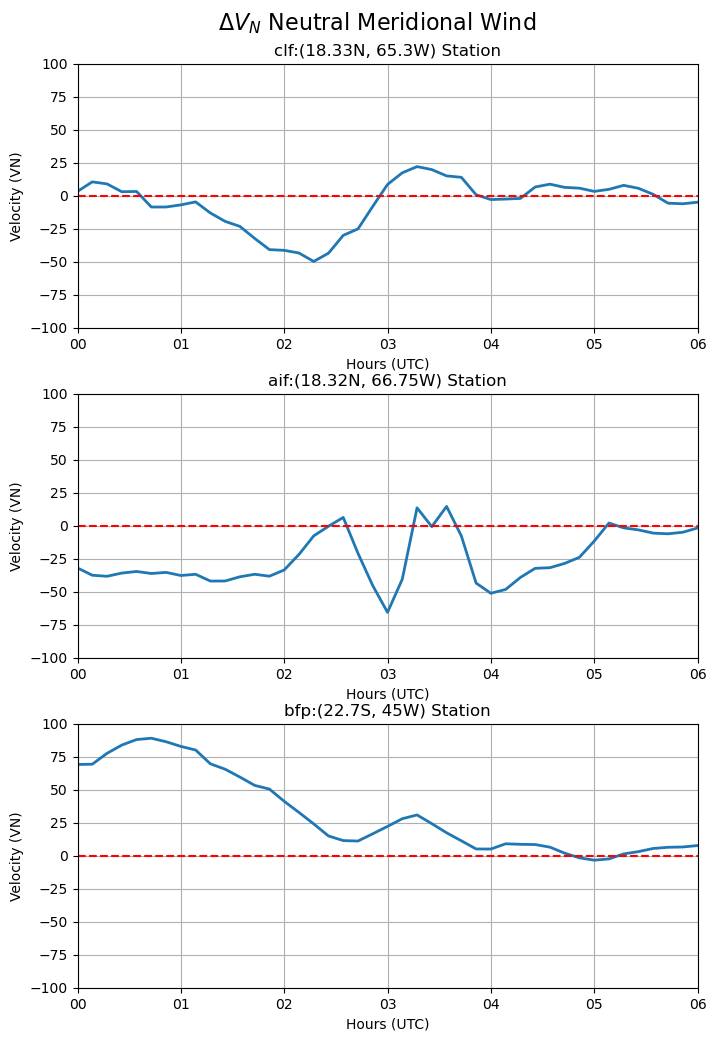

In [74]:
fig=plt.figure(figsize=(8,12))
specs=fig.add_gridspec(3,1,height_ratios=[1,1,1], hspace=0.25)
i=0

for vq, va, tq, ta, s, sl in zip(vn_q, vn_a, time_q, time_a, stations, s_lons):
    #print(vq, va, tq, ta)
    ds_w = xr.Dataset(
        {
            'vq':(['tq'],vq),
            'va':(['ta'],va),
        },
        coords={
             'tq':(['tq'],tq),
             'ta':(['ta'],ta),
        }
    )
    periods = 50
    t_interp = pd.date_range(start='2023-02-22 23:00:00', end='2023-02-23 06:00:00',periods=periods)
    ds_w = ds_w.interp(tq=t_interp)
    ds_w = ds_w.interp(ta=t_interp)
    
    diff = [(j-i) for i, j in zip(ds_w.vq.values, ds_w.va.values)]
    ds_w['v_diff']=(('ta'),diff)
    #print(ds_w)

    
    ax=fig.add_subplot(specs[i,0])
    ax.plot(ds_w.ta, ds_w.v_diff,linewidth=2)
    #ax.plot(ds_w.tq, ds_w.vq, label='quiet')
    #ax.plot(ds_w.ta, ds_w.va, label='active')
    #ax.legend()
    ax.set_title(f'{s}:{sl} Station')
    ax.set_ylim(-100,100)
    xlim_start = pd.Timestamp('2023-02-23 00:00:00')
    xlim_end = pd.Timestamp('2023-02-23 06:00:00')
    ax.set_xlim(xlim_start, xlim_end)
    ax.set_ylabel('Velocity (VN)')
    ax.set_xlabel('Hours (UTC)')
    ax.grid(True)
    ax.axhline(y=0, color='red',linestyle='--')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    
    i+=1
fig.suptitle(r'$\Delta V_N$ Neutral Meridional Wind',fontsize=16, y=0.925)

save_path1 = f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/fabry_perot/diff_meridional_winds.jpg'
plt.savefig(save_path1)


In [107]:
# Example data
dfn = pd.DataFrame({
    'TIMESTAMP': pd.timedelta_range(start='-1 days +23:00:00', periods=24, freq='H'),
    'VALUE': range(24)  # Example values
})

print(dfn)



           TIMESTAMP  VALUE
0  -1 days +23:00:00      0
1    0 days 00:00:00      1
2    0 days 01:00:00      2
3    0 days 02:00:00      3
4    0 days 03:00:00      4
5    0 days 04:00:00      5
6    0 days 05:00:00      6
7    0 days 06:00:00      7
8    0 days 07:00:00      8
9    0 days 08:00:00      9
10   0 days 09:00:00     10
11   0 days 10:00:00     11
12   0 days 11:00:00     12
13   0 days 12:00:00     13
14   0 days 13:00:00     14
15   0 days 14:00:00     15
16   0 days 15:00:00     16
17   0 days 16:00:00     17
18   0 days 17:00:00     18
19   0 days 18:00:00     19
20   0 days 19:00:00     20
21   0 days 20:00:00     21
22   0 days 21:00:00     22
23   0 days 22:00:00     23


# Processing GOLD Data

In [6]:
# file read_single_ni1.py

### Description
# File uses L1C NI1 to plot radiance of 135.6 wavelength
# using 1D array in northern and southern hemisphere  

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

In [7]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

dict_keys(['GRID_EW', 'GRID_NS', 'TIME_ET', 'TIME_UTC', 'WAVELENGTH', 'L1B_TIME_BINS_PER_GRID', 'L1B_PIXELS_PER_GRID', 'QUALITY_FLAG', 'REFERENCE_POINT_LAT', 'REFERENCE_POINT_LON', 'TANGENT_HEIGHT', 'RAY_SOLAR_PHASE_ANGLE', 'RAY_NADIR_ANGLE', 'EMISSION_ANGLE', 'SOLAR_ZENITH_ANGLE', 'RAW_COUNT', 'RAW_COUNT_RANDOM_UNC', 'CORRECTED_COUNT', 'CORRECTED_COUNT_SYSTEMATIC_UNC', 'CORRECTED_COUNT_RANDOM_UNC', 'RADIANCE', 'RADIANCE_SYSTEMATIC_UNC', 'RADIANCE_RANDOM_UNC', 'BACKGROUND_COUNTS'])

Data Dimensions: {'n_ns': <class 'netCDF4._netCDF4.Dimension'>: name = 'n_ns', size = 100, 'n_ew': <class 'netCDF4._netCDF4.Dimension'>: name = 'n_ew', size = 50, 'n_wavelength': <class 'netCDF4._netCDF4.Dimension'>: name = 'n_wavelength', size = 800, 'UTC_String_Length': <class 'netCDF4._netCDF4.Dimension'>: name = 'UTC_String_Length', size = 24}

radiance shape: (100, 50, 800)
solar_zenith_angle shape: (100, 50)
grid_ew shape: (100, 50)
grid_ns shape: (100, 50)
em_1356 shape: (100, 50)
5000 5000 5000


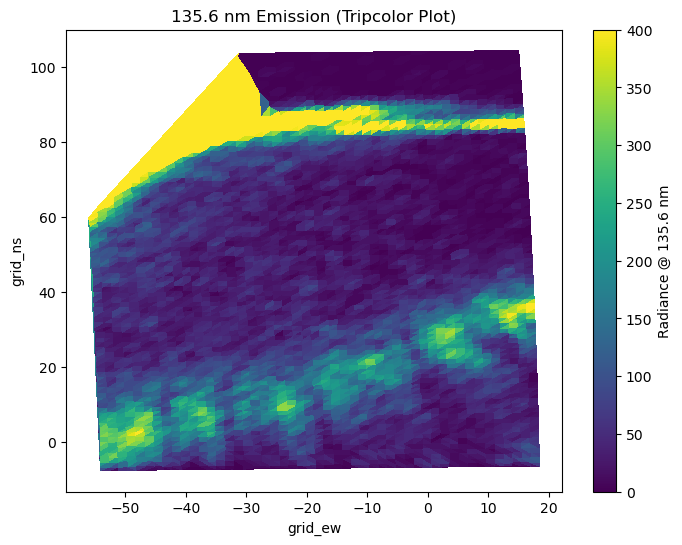

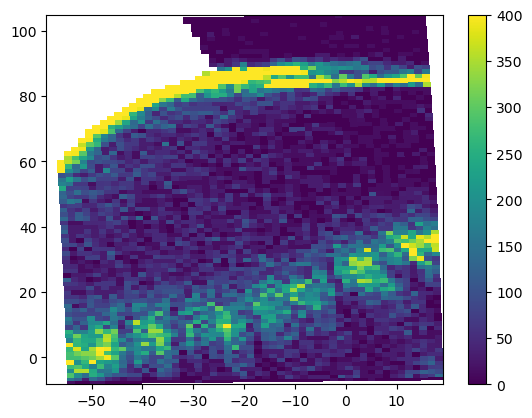

In [45]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

fname = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHA_NI1_2023_056_00_22_v05_r01_c01.nc'
#fname = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHB_NI1_2023_055_20_10_v05_r01_c01.nc'

#fname='/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/050/GOLD_L1C_CHA_NI1_2023_051_00_22_v05_r01_c01.nc'
#fname='/Users/qingyuzhu/Downloads/tmp 2/archive_L1C/2023/051/GOLD_L1C_CHB_NI1_2023_052_00_25_v05_r01_c01.nc'

# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())
print()
print('Data Dimensions:', nc.dimensions)
print()


wavelengths = nc.variables['WAVELENGTH'][:]

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))

grid_ew = nc.variables['GRID_EW'][:] * 10
grid_ns = nc.variables['GRID_NS'][:] * 10

radiance = nc.variables['RADIANCE'][:]
print('radiance shape:',radiance.shape)
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]
print('solar_zenith_angle shape:', sza.shape)

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

#%%

# Flatten your 2D arrays into 1D:
x = grid_ew.ravel()       # shape (N,)
y = grid_ns.ravel()       # shape (N,)
z = em_1356.ravel()       # shape (N,)
#x = np.array(list(grid_ew)*len(grid_ns))       # shape (N,)
#y = np.array([i for i in grid_ns for _ in range(len(grid_ew))])    # shape (N,)

print("grid_ew shape:", grid_ew.shape)
print("grid_ns shape:", grid_ns.shape)
print("em_1356 shape:", em_1356.shape)

# Remove any points where x, y, or z is NaN
print(len(x), len(y), len(z))
mask = np.isnan(x) | np.isnan(y) | np.isnan(z)
x_valid = x[~mask]
y_valid = y[~mask]
z_valid = z[~mask]

# Create a triangulation from these scattered points
triang = tri.Triangulation(x_valid, y_valid)

# Plot with tripcolor (each triangle is colored by z)
plt.figure(figsize=(8,6))
tc = plt.tripcolor(
    triang, z_valid, 
    shading='flat',        # or 'gouraud' for smooth shading
    cmap='viridis', 
    vmin=0, vmax=400
)
plt.colorbar(tc, label='Radiance @ 135.6 nm')
plt.title("135.6 nm Emission (Tripcolor Plot)")
plt.xlabel("grid_ew")
plt.ylabel("grid_ns")
plt.show()

#%%

# Suppose grid_ew.shape, grid_ns.shape, em_1356.shape == (nx, ny)
# Identify rows/columns that are fully valid:
valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]

# Now these sub-arrays (hopefully) contain no NaNs in x or y
plt.figure()
plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=400)
plt.colorbar()
plt.show()

In [52]:
# file show_two_ni1_simple.py

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np


dict_keys(['GRID_EW', 'GRID_NS', 'TIME_ET', 'TIME_UTC', 'WAVELENGTH', 'L1B_TIME_BINS_PER_GRID', 'L1B_PIXELS_PER_GRID', 'QUALITY_FLAG', 'REFERENCE_POINT_LAT', 'REFERENCE_POINT_LON', 'TANGENT_HEIGHT', 'RAY_SOLAR_PHASE_ANGLE', 'RAY_NADIR_ANGLE', 'EMISSION_ANGLE', 'SOLAR_ZENITH_ANGLE', 'RAW_COUNT', 'RAW_COUNT_RANDOM_UNC', 'CORRECTED_COUNT', 'CORRECTED_COUNT_SYSTEMATIC_UNC', 'CORRECTED_COUNT_RANDOM_UNC', 'RADIANCE', 'RADIANCE_SYSTEMATIC_UNC', 'RADIANCE_RANDOM_UNC', 'BACKGROUND_COUNTS'])
grid_ew_sub shape: (85, 50)
grid_ns_sub shape: (85, 50)
em_1356_sub shape: (85, 50)
dict_keys(['GRID_EW', 'GRID_NS', 'TIME_ET', 'TIME_UTC', 'WAVELENGTH', 'L1B_TIME_BINS_PER_GRID', 'L1B_PIXELS_PER_GRID', 'QUALITY_FLAG', 'REFERENCE_POINT_LAT', 'REFERENCE_POINT_LON', 'TANGENT_HEIGHT', 'RAY_SOLAR_PHASE_ANGLE', 'RAY_NADIR_ANGLE', 'EMISSION_ANGLE', 'SOLAR_ZENITH_ANGLE', 'RAW_COUNT', 'RAW_COUNT_RANDOM_UNC', 'CORRECTED_COUNT', 'CORRECTED_COUNT_SYSTEMATIC_UNC', 'CORRECTED_COUNT_RANDOM_UNC', 'RADIANCE', 'RADIANCE_SYST

/tmp/ipykernel_165070/3613062538.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)
/tmp/ipykernel_165070/3613062538.py:107: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


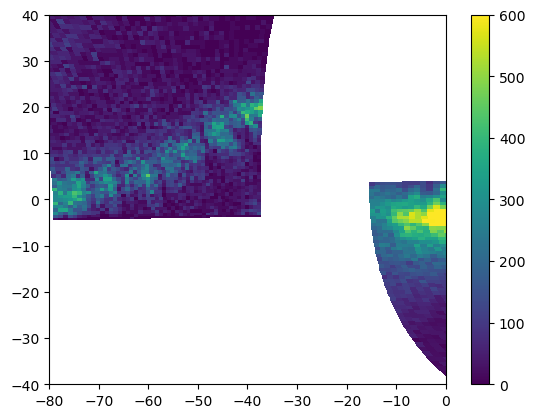

In [53]:
# NH
fname=f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHA_NI1_2023_056_00_22_v05_r01_c01.nc'
#fname='/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/050/GOLD_L1C_CHA_NI1_2023_051_00_22_v05_r01_c01.nc'

# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())



wavelengths = nc.variables['WAVELENGTH'][:]

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))


grid_ew = nc.variables['REFERENCE_POINT_LON'][:] * 1
grid_ns = nc.variables['REFERENCE_POINT_LAT'][:] * 1

radiance = nc.variables['RADIANCE'][:]
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]
grid_ew_sub = np.nan_to_num(grid_ew_sub, nan=0.0, posinf=0.0, neginf=0.0)
grid_ns_sub = np.nan_to_num(grid_ns_sub, nan=0.0, posinf=0.0, neginf=0.0)
em_1356_sub = np.nan_to_num(em_1356_sub, nan=0.0, posinf=0.0, neginf=0.0)
print("grid_ew_sub shape:", grid_ew_sub.shape)
print("grid_ns_sub shape:", grid_ns_sub.shape)
print("em_1356_sub shape:", em_1356_sub.shape)

# Now these sub-arrays (hopefully) contain no NaNs in x or y
plt.figure()
plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


#%% SH
fname=f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHB_NI1_2023_055_20_10_v05_r01_c01.nc'
#fname='/Users/qingyuzhu/Downloads/tmp 2/archive_L1C/2023/051/GOLD_L1C_CHB_NI1_2023_052_00_25_v05_r01_c01.nc'


# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())



wavelengths = nc.variables['WAVELENGTH'][:]

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))


grid_ew = nc.variables['REFERENCE_POINT_LON'][:] * 1
grid_ns = nc.variables['REFERENCE_POINT_LAT'][:] * 1

radiance = nc.variables['RADIANCE'][:]
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]

# Now these sub-arrays (hopefully) contain no NaNs in x or y

plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


plt.xlim(-80,0)
plt.ylim(-40,40)
plt.colorbar()

plt.show()


In [59]:
# file show_two_ni1_map_pair.py

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [61]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

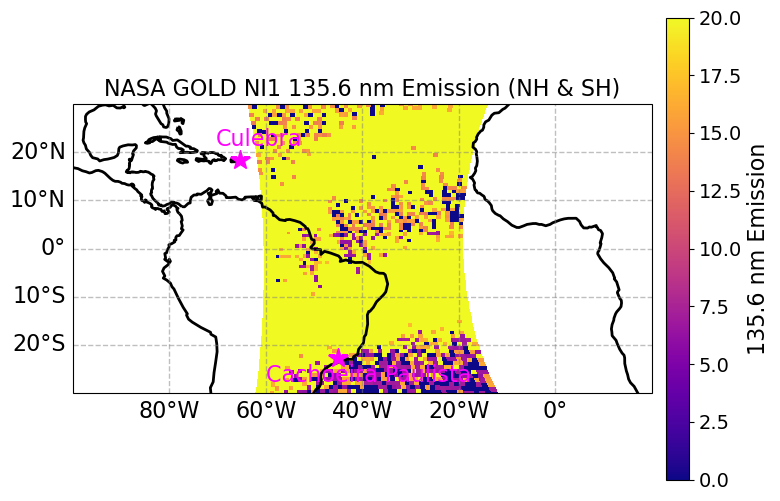

In [64]:
def read_and_subset_ni1(fname, sza_threshold=95.0):
    """
    Reads a GOLD L1C NI1 file, extracts 135.6 nm emission (em_1356) and 
    the REFERENCE_POINT_LON/REFERENCE_POINT_LAT grids, masks daylit areas
    (SZA <= sza_threshold), and returns sub-grids with non-NaN columns/rows removed.

    :param fname: Full path to the GOLD L1C NI1 NetCDF file.
    :param sza_threshold: Solar zenith angle cutoff below which we mask out data (daylit).
    :return: (grid_ew_sub, grid_ns_sub, em_1356_sub) 2D arrays of lon, lat, and emission.
    """
    with Dataset(fname, 'r') as nc:
        # Identify index for 135.6 nm
        wavelengths = nc.variables['WAVELENGTH'][:]  # shape (nx, ny, nw)
        nx, ny, nw = wavelengths.shape
        
        # Create a 1D array of wavelengths by averaging each spectral slice
        wv_1d = np.array([
            np.nanmean(wavelengths[:, :, i]) for i in range(nw)
        ])
        idx_1356 = np.argmin(np.abs(wv_1d - 135.6))

        # Read the coordinate grids (lon & lat)
        grid_ew = nc.variables['REFERENCE_POINT_LON'][:]  # shape (nx, ny)
        grid_ns = nc.variables['REFERENCE_POINT_LAT'][:]  # shape (nx, ny)

        # Extract the 135.6 nm radiance
        radiance = nc.variables['RADIANCE'][:]  # shape (nx, ny, nw)
        em_1356 = radiance[:, :, idx_1356]      # shape (nx, ny)

        # Mask out daylit areas
        sza = nc.variables['SOLAR_ZENITH_ANGLE'][:]  # shape (nx, ny)
        em_1356[sza <= sza_threshold] = np.nan

    # Remove rows/columns that are entirely NaN in the grid_ew
    valid_rows = ~np.isnan(grid_ew).all(axis=1)
    valid_cols = ~np.isnan(grid_ew).all(axis=0)

    # Subset each array
    grid_ew_sub  = grid_ew[valid_rows][:, valid_cols]
    grid_ns_sub  = grid_ns[valid_rows][:, valid_cols]
    em_1356_sub  = em_1356[valid_rows][:, valid_cols]

    return grid_ew_sub, grid_ns_sub, em_1356_sub

def main():
    # Paths to your NI1 files
    fname_nh = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHA_NI1_2023_055_23_10_v05_r01_c01.nc'
    fname_sh = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHB_NI1_2023_055_23_10_v05_r01_c01.nc'
    #fname_nh = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/2019/280/GOLD_L1C_CHB_NI1_2019_280_20_40_v05_r01_c01.nc'
    #fname_sh = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/2019/280/GOLD_L1C_CHB_NI1_2019_280_20_55_v05_r01_c01.nc'

    # Read & subset the NH data
    grid_ew_nh, grid_ns_nh, em_1356_nh = read_and_subset_ni1(fname_nh, sza_threshold=95)

    # Read & subset the SH data
    grid_ew_sh, grid_ns_sh, em_1356_sh = read_and_subset_ni1(fname_sh, sza_threshold=95)

    # Create a Cartopy figure/axis
    fig = plt.figure(figsize=(9, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent (lon_min, lon_max, lat_min, lat_max)
    # Adjust these to focus on the region of interest.
    ax.set_extent([-100, 20, -30, 30], crs=ccrs.PlateCarree())

    # Plot the NH data
    mesh_nh = ax.pcolormesh(grid_ew_nh, grid_ns_nh, em_1356_nh,
                            transform=ccrs.PlateCarree(),
                            shading='auto',
                            vmin=0, vmax=20,
                            cmap='plasma')

    # Plot the SH data
    mesh_sh = ax.pcolormesh(grid_ew_sh, grid_ns_sh, em_1356_sh,
                            transform=ccrs.PlateCarree(),
                            shading='auto',
                            vmin=0, vmax=20,
                            cmap='plasma')

    # Add coastlines, borders, land, etc.
    ax.add_feature(cfeature.COASTLINE, linewidth=2.0)
    #ax.add_feature(cfeature.BORDERS,   linestyle=':')
    #ax.add_feature(cfeature.LAND,      facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN,     facecolor='white')

    # Add gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,      # <-- enables latitude/longitude labels
        linewidth=1,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    
    # Turn off top/right labels (if desired)
    gl.top_labels    = False
    gl.right_labels  = False
    
    # Format lat/lon ticks nicely
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Optionally, customize label style
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}


    # Coordinates to highlight
    lat_spot = -22.703764
    lon_spot = 314.99071  # approx. 314.99071° E
    
    # Add a marker (red star) at that spot
    ax.plot(
        lon_spot, lat_spot,
        marker='*',      # or 'o' for a circle, '^' for triangle, etc.
        markersize=15,   # Adjust size to your preference
        color='magenta',
        transform=ccrs.PlateCarree(),
        label='Highlight Spot'
    )
    
    ax.text(
        lon_spot - 15,  # shift a bit in lon so text is not on top of the marker
        lat_spot - 5,
        "Cachoeira Paulista",
        transform=ccrs.PlateCarree(),
        fontsize=16,
        color='magenta',
        bbox=dict( fc="None", ec="None", alpha=0.8)
    )
    
    #instrument latitude: 18.3298
    #instrument longitude: 294.6932
    
    lat_spot = 18.3298
    lon_spot = 294.6932  # approx. 314.99071° E
    
    # Add a marker (red star) at that spot
    ax.plot(
        lon_spot, lat_spot,
        marker='*',      # or 'o' for a circle, '^' for triangle, etc.
        markersize=15,   # Adjust size to your preference
        color='magenta',
        transform=ccrs.PlateCarree(),
        label='Highlight Spot'
    )
    
    ax.text(
        lon_spot - 5,  # shift a bit in lon so text is not on top of the marker
        lat_spot + 3,
        "Culebra",
        transform=ccrs.PlateCarree(),
        fontsize=16,
        color='magenta',
        bbox=dict( fc="None", ec="None", alpha=0.8)
    )
    
    # Add a colorbar (attaching to one of the mesh objects is fine)
    cbar=fig.colorbar(mesh_sh, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('135.6 nm Emission', fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    #plt.title("NASA GOLD NI1 135.6 nm Emission (NH & SH)")
    ax.set_title("NASA GOLD NI1 135.6 nm Emission (NH & SH)",fontsize=16)
    plt.show()

if __name__ == "__main__":
    main()

In [65]:
# file find_cha_chb.py

from datetime import datetime
import re
import pandas as pd
import os

In [66]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [67]:

# Extract timestamps from filenames
def extract_time(filename):
    match = re.search(r"_(\d{4})_(\d{3})_(\d{2})_(\d{2})_", filename)
    if match:
        year, doy, hour, minute = map(int, match.groups())
        timestamp = datetime.strptime(f"{year} {doy} {hour} {minute}", "%Y %j %H %M")
        return timestamp
    return None

# Pair CHA and CHB filenames by closest timestamps
def find_closest_pairs(cha_files, chb_files):
    cha_times = [(filename, extract_time(filename)) for filename in cha_files]
    chb_times = [(filename, extract_time(filename)) for filename in chb_files]
    closest_pairs = []

    for cha_file, cha_time in cha_times:
        closest_chb = min(chb_times, key=lambda x: abs(x[1] - cha_time))
        closest_pairs.append((cha_file, closest_chb[0], abs(closest_chb[1] - cha_time)))

    return closest_pairs

#%%
rewrite_file = -1 

# Base directory containing year and day-of-year folders
base_dir = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/'
#base_dir = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/'

# Directory to save output CSV files
output_dir = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/pairs/'
#output_dir = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/pairs/'
os.makedirs(output_dir, exist_ok=True)

# Iterate over years and days of year
for year in range(2023, 2024):  # Adjust range as needed
    for doy in range(53, 56):  # 1 to 365 (or 366 for leap years)
        data_dir = os.path.join(base_dir, f"{year}/{doy:03d}/")
        if not os.path.exists(data_dir):
            continue
        
        output_filename = os.path.join(output_dir, f"closest_pairs_{year}_{doy:03d}.csv")
        if (os.path.exists(output_filename)) & (rewrite_file<0):
            print(f"Processed file {output_filename} already exists. Skipping...")
            continue

        # List CHA and CHB files
        cha_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if "CHA" in f and f.endswith(".nc") and not f.startswith("._")]
        chb_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if "CHB" in f and f.endswith(".nc") and not f.startswith("._")]

        if not cha_files or not chb_files:
            continue

        # Find closest pairs
        closest_pairs = find_closest_pairs(cha_files, chb_files)

        # Create a DataFrame for the day's results
        day_results_df = pd.DataFrame(closest_pairs, columns=["CHA File", "CHB File", "Time Difference"])
        day_results_df.sort_values("Time Difference", inplace=True)

        # Save results to a CSV file for the specific day
        
        day_results_df.to_csv(output_filename, index=False)

        print(f"Closest pairs for {year} DOY {doy} saved to '{output_filename}'")


Closest pairs for 2023 DOY 53 saved to '/home/pxv220016/scratch/Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/pairs/closest_pairs_2023_053.csv'
Closest pairs for 2023 DOY 54 saved to '/home/pxv220016/scratch/Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/pairs/closest_pairs_2023_054.csv'
Closest pairs for 2023 DOY 55 saved to '/home/pxv220016/scratch/Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/pairs/closest_pairs_2023_055.csv'


In [75]:
# file show_ni1_pair_map.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 28 07:46:48 2024

@author: qingyuzhu
"""

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
import datetime as dt
import re
import os
import pandas as pd
from tqdm import tqdm

In [69]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [77]:

#%%
def read_and_subset_ni1(fname, sza_threshold=95.0):
    """
    Reads a GOLD L1C NI1 file, extracts 135.6 nm emission (em_1356) and 
    the REFERENCE_POINT_LON/REFERENCE_POINT_LAT grids, masks daylit areas
    (SZA <= sza_threshold), and returns sub-grids with non-NaN columns/rows removed.

    :param fname: Full path to the GOLD L1C NI1 NetCDF file.
    :param sza_threshold: Solar zenith angle cutoff below which we mask out data (daylit).
    :return: (grid_ew_sub, grid_ns_sub, em_1356_sub) 2D arrays of lon, lat, and emission.
    """
    with Dataset(fname, 'r') as nc:
        # Identify index for 135.6 nm
        wavelengths = nc.variables['WAVELENGTH'][:]  # shape (nx, ny, nw)
        nx, ny, nw = wavelengths.shape
        
        # Create a 1D array of wavelengths by averaging each spectral slice
        wv_1d = np.array([
            np.nanmean(wavelengths[:, :, i]) for i in range(nw)
        ])
        idx_1356 = np.argmin(np.abs(wv_1d - 135.6))

        # Read the coordinate grids (lon & lat)
        grid_ew = nc.variables['REFERENCE_POINT_LON'][:]  # shape (nx, ny)
        grid_ns = nc.variables['REFERENCE_POINT_LAT'][:]  # shape (nx, ny)

        # Extract the 135.6 nm radiance
        radiance = nc.variables['RADIANCE'][:]  # shape (nx, ny, nw)
        em_1356 = radiance[:, :, idx_1356]      # shape (nx, ny)

        # Mask out daylit areas
        sza = nc.variables['SOLAR_ZENITH_ANGLE'][:]  # shape (nx, ny)
        em_1356[sza <= sza_threshold] = np.nan

    # Remove rows/columns that are entirely NaN in the grid_ew
    valid_rows = ~np.isnan(grid_ew).all(axis=1)
    valid_cols = ~np.isnan(grid_ew).all(axis=0)

    # Subset each array
    grid_ew_sub  = grid_ew[valid_rows][:, valid_cols]
    grid_ns_sub  = grid_ns[valid_rows][:, valid_cols]
    em_1356_sub  = em_1356[valid_rows][:, valid_cols]

    return grid_ew_sub, grid_ns_sub, em_1356_sub

#%%
def extract_datetime_from_filename(filename):
    """Extract datetime from GOLD L1C filename."""
    match = re.search(r"_(\d{4})_(\d{3})_(\d{2})_(\d{2})_", filename)
    if match:
        year, doy, hour, minute = map(int, match.groups())
        date = datetime.strptime(f"{year} {doy} {hour} {minute}", "%Y %j %H %M")
        return date
    return None

#%%
def plot_ni1_maps(cha_data, chb_data, cha_file, chb_file, output_figure_path):
    """
    Plots the NI1 data for CHA and CHB in one plot.

    Parameters:
    - cha_data: Data from CHA file 
    - chb_data: Data from CHB file 
    - cha_file: File name for CHA data.
    - chb_file: File name for CHB data.
    - output_figure_path: Path to save the output figure.
    """
    # Extract average datetime
    cha_datetime = extract_datetime_from_filename(cha_file)
    chb_datetime = extract_datetime_from_filename(chb_file)
    if cha_datetime and chb_datetime:
        avg_datetime = cha_datetime + (chb_datetime - cha_datetime) / 2
        title = avg_datetime.strftime("%Y-%m-%d %H:%M")
    else:
        title = "CHA and CHB Data Combined"
        
    # Read & subset the NH data
    grid_ew_nh, grid_ns_nh, em_1356_nh = read_and_subset_ni1(cha_data, sza_threshold=95)

    # Read & subset the SH data
    grid_ew_sh, grid_ns_sh, em_1356_sh = read_and_subset_ni1(chb_data, sza_threshold=95)
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.set_title(title,fontsize=16)
    ax.set_extent([-100, 20, -30, 30], crs=ccrs.PlateCarree())

    # Plot the NH data
    mesh_nh = ax.pcolormesh(grid_ew_nh, grid_ns_nh, em_1356_nh,
                            transform=ccrs.PlateCarree(),
                            shading='auto',
                            vmin=0, vmax=80,
                            cmap='plasma')

    # Plot the SH data
    mesh_sh = ax.pcolormesh(grid_ew_sh, grid_ns_sh, em_1356_sh,
                            transform=ccrs.PlateCarree(),
                            shading='auto',
                            vmin=0, vmax=80,
                            cmap='plasma')

    # Add coastlines, borders, land, etc.
    ax.add_feature(cfeature.COASTLINE, linewidth=2.0)
    #ax.add_feature(cfeature.BORDERS,   linestyle=':')
    #ax.add_feature(cfeature.LAND,      facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN,     facecolor='white')
    
    # Add gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,      # <-- enables latitude/longitude labels
        linewidth=1,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    
    # Turn off top/right labels (if desired)
    gl.top_labels    = False
    gl.right_labels  = False
    
    # Format lat/lon ticks nicely
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Optionally, customize label style
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    # Coordinates to highlight
    lat_spot = -22.703764
    lon_spot = 314.99071  # approx. 314.99071° E
    
    # Add a marker (red star) at that spot
    ax.plot(
        lon_spot, lat_spot,
        marker='*',      # or 'o' for a circle, '^' for triangle, etc.
        markersize=15,   # Adjust size to your preference
        color='magenta',
        transform=ccrs.PlateCarree(),
        label='Highlight Spot'
    )
    
    ax.text(
        lon_spot - 15,  # shift a bit in lon so text is not on top of the marker
        lat_spot - 5,
        "Cachoeira Paulista",
        transform=ccrs.PlateCarree(),
        fontsize=16,
        color='magenta',
        bbox=dict( fc="None", ec="None", alpha=0.8)
    )
    
    lat_spot = 18.3298
    lon_spot = 294.6932  # approx. 314.99071° E
    
    # Add a marker (red star) at that spot
    ax.plot(
        lon_spot, lat_spot,
        marker='*',      # or 'o' for a circle, '^' for triangle, etc.
        markersize=15,   # Adjust size to your preference
        color='magenta',
        transform=ccrs.PlateCarree(),
        label='Highlight Spot'
    )
    
    ax.text(
        lon_spot - 5,  # shift a bit in lon so text is not on top of the marker
        lat_spot + 3,
        "Culebra",
        transform=ccrs.PlateCarree(),
        fontsize=16,
        color='magenta',
        bbox=dict( fc="None", ec="None", alpha=0.8)
    )
    
    # Add a colorbar (attaching to one of the mesh objects is fine)
    cbar = fig.colorbar(mesh_sh, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    cbar.set_label('135.6 nm Emission', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.savefig(output_figure_path+avg_datetime.strftime("%Y%m%d_%H%M"))
    plt.close(fig)


#%%
def adjust_doy_for_filename(datetime_obj, threshold_hour=6):
    """
    Adjusts the DOY in the filename based on a time threshold.
    If the hour is less than the threshold, subtract one day.

    :param datetime_obj: Datetime object extracted from the filename.
    :param threshold_hour: Hour threshold to decide the DOY adjustment.
    :return: Adjusted year and DOY as integers.
    """
    if datetime_obj.hour < threshold_hour:
        datetime_obj -= dt.timedelta(days=1)
    return datetime_obj.year, datetime_obj.timetuple().tm_yday
#%%
rewrite_file = -1 

# Directories
input_dir = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/pairs/'
#input_dir = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/pairs/'  # Directory containing the CSV files
output_fig_dir = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/figures'
#output_fig_dir = '/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/figures/'  # Directory to save figures
os.makedirs(output_fig_dir, exist_ok=True)

# List all CSV files in the directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv") and not f.startswith("._")]

for csv_file in tqdm(csv_files):
    csv_path = os.path.join(input_dir, csv_file)
    df = pd.read_csv(csv_path)

    npair = len(df)
    
    for index, row in df.iterrows():
        cha_file = row["CHA File"]
        chb_file = row["CHB File"]
        
        
        cha_datetime = extract_datetime_from_filename(cha_file)
        chb_datetime = extract_datetime_from_filename(chb_file)

        avg_datetime = cha_datetime + (chb_datetime - cha_datetime) / 2
        
        if avg_datetime.hour<6:
            avg_datetime1=avg_datetime - dt.timedelta(days=1) 
        else:
            avg_datetime1=avg_datetime
            
            
            
        save_year=avg_datetime1.year 
        save_doy =avg_datetime1.timetuple().tm_yday
        

        
        output_figure_path = os.path.join(output_fig_dir, f"{save_year}/{save_doy:03d}/")
        os.makedirs(output_figure_path, exist_ok=True)
        
        fig_files = [f for f in os.listdir(output_figure_path) if f.endswith(".png") and not f.startswith("._")]
        

        if (len(fig_files)==npair)&(rewrite_file<0):
            continue
        
        try:
            plot_ni1_maps(cha_file, chb_file, cha_file, chb_file, output_figure_path)
            print ()
            #print(f"Figure created for {cha_file} and {chb_file}, saved to {output_figure_path}")
        except Exception as e:
            print ()
            print(f"Failed to process {cha_file} and {chb_file}: {e}")

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 44.06it/s]
